In [ ]:
import collections
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F

#### Mount the drive

In [ ]:
BASE_PATH = "/kaggle/input/sartorius-cell-instance-segmentation"

In [ ]:
"""
Function to make results reproducible
"""
def __set__seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)  # seed for cpu
    torch.cuda.manual_seed(seed)  # seed for gpu
    torch.cuda.manual_seed_all(seed)

__set__seeds(2024)

In [6]:
TRAIN_PATH = f"{BASE_PATH}/train"
TEST_PATH = f"{BASE_PATH}/test"
TRAIN_CSV = f"{BASE_PATH}/train.csv"
TEST = False

In [7]:
# CSV - for test read only 5000 rows
df = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


#### Historgram for class distribution

In [8]:
df.head()
cell_type_counts = df['cell_type'].value_counts()
print(cell_type_counts)

cell_type
shsy5y    52286
cort      10777
astro     10522
Name: count, dtype: int64


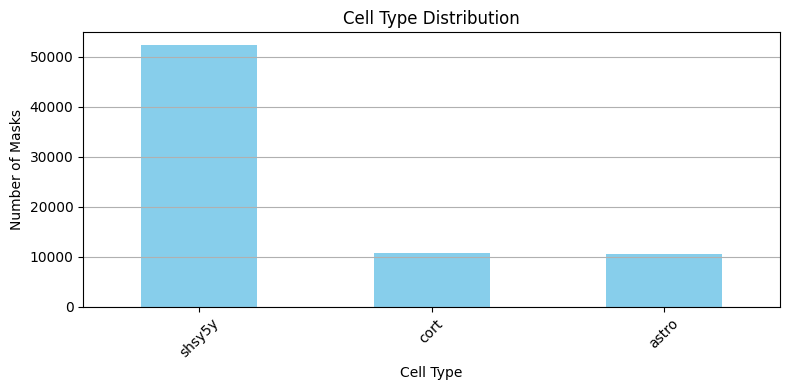

In [9]:
# Class histogram by cell type
plt.figure(figsize=(8, 4))
df['cell_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Cell Type Distribution")
plt.xlabel("Cell Type")
plt.ylabel("Number of Masks")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Make the train/validation split from the train folder 80/20

In [10]:
unique_ids = df['id'].unique()
print(f"Total unique images: {len(unique_ids)}")

Total unique images: 606


In [ ]:
# 90% train, 10% validation
train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

In [ ]:
train_df = df[df['id'].isin(train_ids)].reset_index(drop=True)
val_df = df[df['id'].isin(val_ids)].reset_index(drop=True)

print(
    f"Train images: {train_df['id'].nunique()} | "
    f"Val images: {val_df['id'].nunique()}"
)

Train images: 545 | Val images: 61


In [13]:
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

train_image_ids = train_df['id'].unique().tolist()
val_image_ids = val_df['id'].unique().tolist()

#### Visualize image and mask

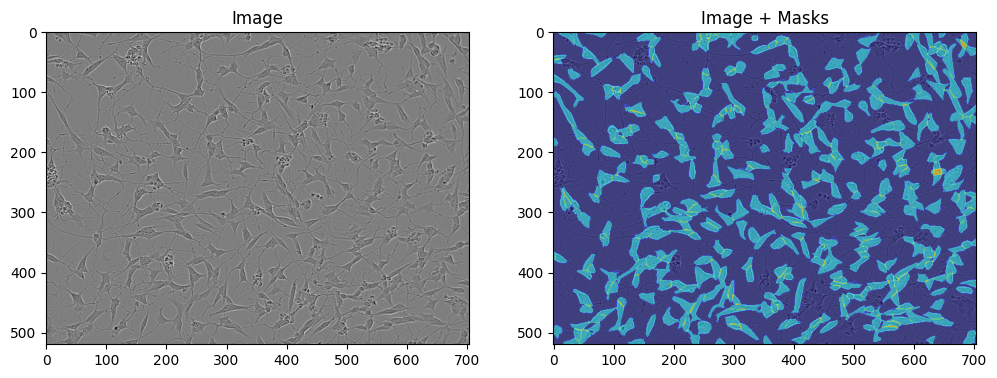

In [ ]:
def rle_decode(mask_rle, shape=(520, 704)):
    s = mask_rle.strip().split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def visualize_sample(image_id, df, img_dir):
    img_path = os.path.join(img_dir, f"{image_id}.png")
    image = np.array(Image.open(img_path))

    masks = df[df['id'] == image_id]['annotation'].tolist()
    combined_mask = np.zeros_like(image, dtype=np.uint8)

    for i, rle in enumerate(masks):
        mask = rle_decode(rle)
        combined_mask += mask.astype(np.uint8)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(combined_mask, alpha=0.5, cmap='jet')
    plt.title('Image + Masks')
    plt.show()

# Example on id 0
visualize_sample(train_image_ids[0], df, TRAIN_PATH)


In [ ]:
DEVICE = (
    torch.device('cuda')
    if torch.cuda.is_available()
    else torch.device('cpu')
)

IMG_WIDTH = 704
IMG_HEIGHT = 520

# To normalize
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 2

MOMENTUM = 0.9
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
MASK_THRESHOLD = 0.5

# Normalize to resnet mean and std
NORMALIZE = True

USE_SCHEDULER = True
NUM_EPOCHS = 50
BOX_DETECTIONS_PER_IMG = 539

CELL_TYPE_DICT = {"astro": 1, "cort": 2, "shsy5y": 3}
DICT_TO_CELL = {1: "astro", 2: "cort", 3: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}
NUM_CLASSES = len(CELL_TYPE_DICT)

### Run-Length Encoding (RLE) encoding for masks

In [ ]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [ ]:
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def draw_box(box):
    result = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    xmin = int(box[0])
    ymin = int(box[1])
    xmax = int(box[2])
    ymax = int(box[3])

    for x in range(xmin, xmax):
        if (xmin != 0) and (xmax != IMG_WIDTH):
            result[ymin-1][x] = 1
            result[ymax-1][x] = 1

    for y in range(ymin, ymax):
        if (ymin != 0) and (ymax != IMG_HEIGHT):
            result[y][xmax - 1] = 1
            result[y][xmin - 1] = 1

    return result

# Get bbox of given mask
def get_box(a_mask):
    pos = np.where(a_mask)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])

    return [xmin, ymin, xmax, ymax]

# Mask + img
def combine_masks(masks, mask_threshold):
    maskimg = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    for m, mask in enumerate(masks, 1):
        maskimg[mask > mask_threshold] = m
    return maskimg

# Mask + bbox
def combine_masks_boxes(masks, boxes):
    result = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    cur_max = 0
    for i in range(IMG_WIDTH):
        for j in range(IMG_HEIGHT):

            result[j][i] = 0

            if masks[j][i] != 0:
                result[j][i] = masks[j][i]
                if masks[j][i] > cur_max:
                    cur_max = masks[j][i]

    for i in range(IMG_WIDTH):
        for j in range(IMG_HEIGHT):
            if boxes[j][i] != 0:
                result[j][i] = cur_max           
    return result

"""
Filter masks using MIN_SCORE for mask 
and MAX_THRESHOLD for pixels
"""
def get_filtered_masks(pred):
    use_masks = []
    for i, mask in enumerate(pred["masks"]):
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > MIN_SCORE_DICT[label]:
            mask = mask.cpu().numpy().squeeze()
            binary_mask = mask > MASK_THRESHOLD_DICT[label]
            binary_mask = remove_overlapping_pixels(
                binary_mask, use_masks
                )
            use_masks.append(binary_mask)

    return use_masks

In [ ]:
"""
Computes the IoU for instance labels and predictions
"""
def compute_iou(labels, y_pred, verbose=0):
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    # exclude background
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union

    return iou  

"""
Computes the precision at a given threshold.
"""
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

"""
Computes the metric for the competition.
"""
def iou_map(truths, preds, verbose=0):
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

"""
Get average IOU mAP score for a dataset
"""
def get_score(ds, mdl):
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = MASK_THRESHOLD_DICT[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    if train: 
        if NORMALIZE: 
            transforms.append(Normalize())
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [ ]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.height = IMG_HEIGHT
        self.width = IMG_WIDTH
        self.image_info = collections.defaultdict(dict)

        temp_df = self.df.groupby(['id', 'cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
        
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': row["annotation"],
                    'cell_type': CELL_TYPE_DICT[row["cell_type"]]
                    }

    def __getitem__(self, idx):
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        info = self.image_info[idx]
        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []

        for i, annotation in enumerate(info['annotations']):
            
            a_mask = rle_decode(annotation, (IMG_HEIGHT, IMG_WIDTH))
            a_mask = Image.fromarray(a_mask)
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            boxes.append(get_box(a_mask))

        labels = [info["cell_type"] for _ in range(n_objects)]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.image_info)

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# DataLoader for training
train_dataset = CellDataset(TRAIN_PATH, df, transforms=get_transform(train=True))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=2, collate_fn=collate_fn)

# DataLoader for validation
val_dataset = CellDataset(TRAIN_PATH, val_df, transforms=get_transform(train=False))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, collate_fn=collate_fn)


In [ ]:
def show_batch(images, targets, max_images=4):
    plt.figure(figsize=(16, 4 * max_images))

    for i in range(min(max_images, len(images))):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        # denomarlization ImageNet
        image = np.clip(image * 0.229 + 0.485, 0, 1)
        masks = targets[i]["masks"].cpu().numpy()
        combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for mask in masks:
            combined_mask = np.maximum(combined_mask, mask)

        plt.subplot(max_images, 2, 2 * i + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(max_images, 2, 2 * i + 2)
        plt.imshow(image)
        plt.imshow(combined_mask, alpha=0.5, cmap='viridis')
        plt.title("Image + Masks")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

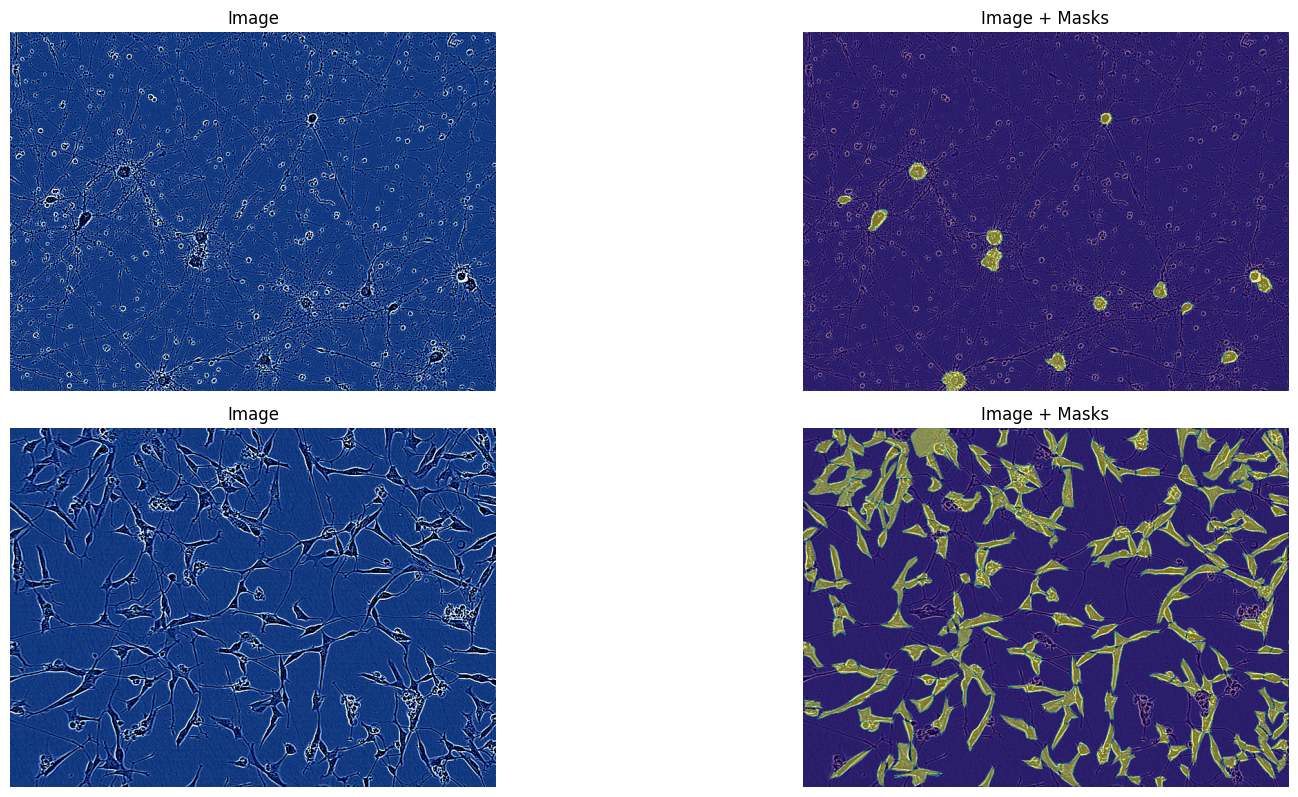

In [24]:
# Récupère un batch et affiche
images, targets = next(iter(train_loader))
show_batch(images, targets)

## Training

### Download pretrained weights from link below
https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [ ]:
# Load COCO-pretrained weights
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None, weights_backbone=None)
state_dict = torch.load("//kaggle/input/pretrained/maskrcnn_resnet50_fpn_coco_0.15.1.pth")
model.load_state_dict(state_dict)

# Replace classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES + 1)

# Replace mask head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES + 1)

model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True

model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_loss, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_epoch = epoch
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            print(f"EarlyStopping: {self.counter} / {self.patience} without improvement.")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.best_epoch = epoch
            self.counter = 0

In [28]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
n_batches, n_batches_val = len(train_loader), len(val_loader)

In [ ]:
validation_mask_losses = []
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0

    for batch_idx, (images, targets) in enumerate(tqdm(train_loader), 1):
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum += loss_dict['loss_classifier'].item()

    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches

    if USE_SCHEDULER and epoch >= 5:
        lr_scheduler.step()
    
    # Validation
    val_loss_epoch = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(val_loader), 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_epoch += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    val_loss = val_loss_epoch / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    #time per epoch
    epoch_time = time.time() - time_start

    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    validation_mask_losses.append(val_loss_mask)

    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    print(f"[Epoch {epoch} / {NUM_EPOCHS}] Train-mask loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
    print(f"[Epoch {epoch} / {NUM_EPOCHS}] Val-mask loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
    print(f"[Epoch {epoch} / {NUM_EPOCHS}] Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f}")
    print(f"Time for epoch {epoch}: {epoch_time:.2f} seconds")

100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


[Epoch 1 / 50] Train-mask loss:   0.450, classifier loss   0.541
[Epoch 1 / 50] Val-mask loss  :   0.364, classifier loss   0.452
[Epoch 1 / 50] Train loss:   2.242. Val loss:   2.049
Time for epoch 1: 203.98 seconds


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


[Epoch 2 / 50] Train-mask loss:   0.355, classifier loss   0.443
[Epoch 2 / 50] Val-mask loss  :   0.348, classifier loss   0.394
[Epoch 2 / 50] Train loss:   1.941. Val loss:   1.882
Time for epoch 2: 208.23 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 3 / 50] Train-mask loss:   0.343, classifier loss   0.409
[Epoch 3 / 50] Val-mask loss  :   0.341, classifier loss   0.382
[Epoch 3 / 50] Train loss:   1.859. Val loss:   1.830
Time for epoch 3: 204.67 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 4 / 50] Train-mask loss:   0.338, classifier loss   0.386
[Epoch 4 / 50] Val-mask loss  :   0.338, classifier loss   0.368
[Epoch 4 / 50] Train loss:   1.803. Val loss:   1.817
Time for epoch 4: 208.73 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 5 / 50] Train-mask loss:   0.335, classifier loss   0.366
[Epoch 5 / 50] Val-mask loss  :   0.334, classifier loss   0.347
[Epoch 5 / 50] Train loss:   1.749. Val loss:   1.752
Time for epoch 5: 201.70 seconds


100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[Epoch 6 / 50] Train-mask loss:   0.332, classifier loss   0.354
[Epoch 6 / 50] Val-mask loss  :   0.326, classifier loss   0.322
[Epoch 6 / 50] Train loss:   1.725. Val loss:   1.686
Time for epoch 6: 207.69 seconds


100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


[Epoch 7 / 50] Train-mask loss:   0.330, classifier loss   0.345
[Epoch 7 / 50] Val-mask loss  :   0.326, classifier loss   0.329
[Epoch 7 / 50] Train loss:   1.694. Val loss:   1.679
Time for epoch 7: 202.91 seconds


100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


[Epoch 8 / 50] Train-mask loss:   0.327, classifier loss   0.335
[Epoch 8 / 50] Val-mask loss  :   0.323, classifier loss   0.321
[Epoch 8 / 50] Train loss:   1.653. Val loss:   1.636
Time for epoch 8: 208.91 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 9 / 50] Train-mask loss:   0.327, classifier loss   0.330
[Epoch 9 / 50] Val-mask loss  :   0.325, classifier loss   0.317
[Epoch 9 / 50] Train loss:   1.641. Val loss:   1.639
Time for epoch 9: 209.24 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 10 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 10 / 50] Val-mask loss  :   0.325, classifier loss   0.315
[Epoch 10 / 50] Train loss:   1.638. Val loss:   1.635
Time for epoch 10: 205.73 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 11 / 50] Train-mask loss:   0.325, classifier loss   0.331
[Epoch 11 / 50] Val-mask loss  :   0.322, classifier loss   0.318
[Epoch 11 / 50] Train loss:   1.637. Val loss:   1.636
Time for epoch 11: 208.33 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 12 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 12 / 50] Val-mask loss  :   0.324, classifier loss   0.315
[Epoch 12 / 50] Train loss:   1.635. Val loss:   1.640
Time for epoch 12: 202.60 seconds


100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


[Epoch 13 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 13 / 50] Val-mask loss  :   0.329, classifier loss   0.316
[Epoch 13 / 50] Train loss:   1.640. Val loss:   1.643
Time for epoch 13: 209.42 seconds


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


[Epoch 14 / 50] Train-mask loss:   0.326, classifier loss   0.328
[Epoch 14 / 50] Val-mask loss  :   0.325, classifier loss   0.311
[Epoch 14 / 50] Train loss:   1.633. Val loss:   1.618
Time for epoch 14: 203.94 seconds


100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


[Epoch 15 / 50] Train-mask loss:   0.325, classifier loss   0.331
[Epoch 15 / 50] Val-mask loss  :   0.325, classifier loss   0.316
[Epoch 15 / 50] Train loss:   1.635. Val loss:   1.646
Time for epoch 15: 206.66 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 16 / 50] Train-mask loss:   0.326, classifier loss   0.331
[Epoch 16 / 50] Val-mask loss  :   0.324, classifier loss   0.314
[Epoch 16 / 50] Train loss:   1.639. Val loss:   1.648
Time for epoch 16: 207.01 seconds


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


[Epoch 17 / 50] Train-mask loss:   0.325, classifier loss   0.331
[Epoch 17 / 50] Val-mask loss  :   0.323, classifier loss   0.318
[Epoch 17 / 50] Train loss:   1.636. Val loss:   1.626
Time for epoch 17: 204.40 seconds


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


[Epoch 18 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 18 / 50] Val-mask loss  :   0.324, classifier loss   0.314
[Epoch 18 / 50] Train loss:   1.637. Val loss:   1.629
Time for epoch 18: 201.85 seconds


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


[Epoch 19 / 50] Train-mask loss:   0.326, classifier loss   0.332
[Epoch 19 / 50] Val-mask loss  :   0.323, classifier loss   0.312
[Epoch 19 / 50] Train loss:   1.640. Val loss:   1.627
Time for epoch 19: 205.02 seconds


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


[Epoch 20 / 50] Train-mask loss:   0.327, classifier loss   0.332
[Epoch 20 / 50] Val-mask loss  :   0.325, classifier loss   0.310
[Epoch 20 / 50] Train loss:   1.642. Val loss:   1.636
Time for epoch 20: 204.94 seconds


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


[Epoch 21 / 50] Train-mask loss:   0.325, classifier loss   0.330
[Epoch 21 / 50] Val-mask loss  :   0.325, classifier loss   0.313
[Epoch 21 / 50] Train loss:   1.638. Val loss:   1.646
Time for epoch 21: 207.46 seconds


100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


[Epoch 22 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 22 / 50] Val-mask loss  :   0.327, classifier loss   0.315
[Epoch 22 / 50] Train loss:   1.633. Val loss:   1.639
Time for epoch 22: 206.44 seconds


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


[Epoch 23 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 23 / 50] Val-mask loss  :   0.325, classifier loss   0.310
[Epoch 23 / 50] Train loss:   1.635. Val loss:   1.625
Time for epoch 23: 207.48 seconds


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


[Epoch 24 / 50] Train-mask loss:   0.325, classifier loss   0.330
[Epoch 24 / 50] Val-mask loss  :   0.327, classifier loss   0.319
[Epoch 24 / 50] Train loss:   1.637. Val loss:   1.659
Time for epoch 24: 199.89 seconds


100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


[Epoch 25 / 50] Train-mask loss:   0.326, classifier loss   0.331
[Epoch 25 / 50] Val-mask loss  :   0.325, classifier loss   0.312
[Epoch 25 / 50] Train loss:   1.639. Val loss:   1.633
Time for epoch 25: 208.23 seconds


100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


[Epoch 26 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 26 / 50] Val-mask loss  :   0.325, classifier loss   0.316
[Epoch 26 / 50] Train loss:   1.638. Val loss:   1.634
Time for epoch 26: 206.00 seconds


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


[Epoch 27 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 27 / 50] Val-mask loss  :   0.324, classifier loss   0.314
[Epoch 27 / 50] Train loss:   1.630. Val loss:   1.627
Time for epoch 27: 209.87 seconds


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


[Epoch 28 / 50] Train-mask loss:   0.328, classifier loss   0.331
[Epoch 28 / 50] Val-mask loss  :   0.326, classifier loss   0.311
[Epoch 28 / 50] Train loss:   1.642. Val loss:   1.628
Time for epoch 28: 204.71 seconds


100%|██████████| 31/31 [00:15<00:00,  2.07it/s]


[Epoch 29 / 50] Train-mask loss:   0.326, classifier loss   0.331
[Epoch 29 / 50] Val-mask loss  :   0.324, classifier loss   0.315
[Epoch 29 / 50] Train loss:   1.635. Val loss:   1.643
Time for epoch 29: 205.98 seconds


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


[Epoch 30 / 50] Train-mask loss:   0.327, classifier loss   0.330
[Epoch 30 / 50] Val-mask loss  :   0.325, classifier loss   0.317
[Epoch 30 / 50] Train loss:   1.639. Val loss:   1.640
Time for epoch 30: 204.01 seconds


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


[Epoch 31 / 50] Train-mask loss:   0.327, classifier loss   0.330
[Epoch 31 / 50] Val-mask loss  :   0.326, classifier loss   0.315
[Epoch 31 / 50] Train loss:   1.634. Val loss:   1.642
Time for epoch 31: 202.98 seconds


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


[Epoch 32 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 32 / 50] Val-mask loss  :   0.324, classifier loss   0.316
[Epoch 32 / 50] Train loss:   1.637. Val loss:   1.630
Time for epoch 32: 201.71 seconds


100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


[Epoch 33 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 33 / 50] Val-mask loss  :   0.324, classifier loss   0.314
[Epoch 33 / 50] Train loss:   1.637. Val loss:   1.634
Time for epoch 33: 202.37 seconds


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


[Epoch 34 / 50] Train-mask loss:   0.325, classifier loss   0.331
[Epoch 34 / 50] Val-mask loss  :   0.325, classifier loss   0.316
[Epoch 34 / 50] Train loss:   1.638. Val loss:   1.640
Time for epoch 34: 204.75 seconds


100%|██████████| 31/31 [00:15<00:00,  2.07it/s]


[Epoch 35 / 50] Train-mask loss:   0.325, classifier loss   0.331
[Epoch 35 / 50] Val-mask loss  :   0.324, classifier loss   0.315
[Epoch 35 / 50] Train loss:   1.634. Val loss:   1.631
Time for epoch 35: 204.94 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 36 / 50] Train-mask loss:   0.326, classifier loss   0.333
[Epoch 36 / 50] Val-mask loss  :   0.325, classifier loss   0.317
[Epoch 36 / 50] Train loss:   1.640. Val loss:   1.639
Time for epoch 36: 202.91 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 37 / 50] Train-mask loss:   0.326, classifier loss   0.331
[Epoch 37 / 50] Val-mask loss  :   0.324, classifier loss   0.312
[Epoch 37 / 50] Train loss:   1.635. Val loss:   1.641
Time for epoch 37: 201.14 seconds


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


[Epoch 38 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 38 / 50] Val-mask loss  :   0.325, classifier loss   0.314
[Epoch 38 / 50] Train loss:   1.640. Val loss:   1.637
Time for epoch 38: 207.72 seconds


100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


[Epoch 39 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 39 / 50] Val-mask loss  :   0.326, classifier loss   0.319
[Epoch 39 / 50] Train loss:   1.636. Val loss:   1.640
Time for epoch 39: 200.67 seconds


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


[Epoch 40 / 50] Train-mask loss:   0.327, classifier loss   0.331
[Epoch 40 / 50] Val-mask loss  :   0.325, classifier loss   0.318
[Epoch 40 / 50] Train loss:   1.640. Val loss:   1.649
Time for epoch 40: 199.96 seconds


100%|██████████| 31/31 [00:14<00:00,  2.09it/s]


[Epoch 41 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 41 / 50] Val-mask loss  :   0.325, classifier loss   0.317
[Epoch 41 / 50] Train loss:   1.637. Val loss:   1.644
Time for epoch 41: 203.52 seconds


100%|██████████| 31/31 [00:14<00:00,  2.12it/s]


[Epoch 42 / 50] Train-mask loss:   0.327, classifier loss   0.332
[Epoch 42 / 50] Val-mask loss  :   0.323, classifier loss   0.311
[Epoch 42 / 50] Train loss:   1.644. Val loss:   1.635
Time for epoch 42: 203.28 seconds


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


[Epoch 43 / 50] Train-mask loss:   0.326, classifier loss   0.331
[Epoch 43 / 50] Val-mask loss  :   0.325, classifier loss   0.315
[Epoch 43 / 50] Train loss:   1.641. Val loss:   1.648
Time for epoch 43: 209.56 seconds


100%|██████████| 31/31 [00:14<00:00,  2.10it/s]


[Epoch 44 / 50] Train-mask loss:   0.326, classifier loss   0.326
[Epoch 44 / 50] Val-mask loss  :   0.324, classifier loss   0.316
[Epoch 44 / 50] Train loss:   1.634. Val loss:   1.637
Time for epoch 44: 201.71 seconds


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


[Epoch 45 / 50] Train-mask loss:   0.326, classifier loss   0.332
[Epoch 45 / 50] Val-mask loss  :   0.327, classifier loss   0.313
[Epoch 45 / 50] Train loss:   1.643. Val loss:   1.628
Time for epoch 45: 206.54 seconds


100%|██████████| 31/31 [00:14<00:00,  2.08it/s]


[Epoch 46 / 50] Train-mask loss:   0.326, classifier loss   0.333
[Epoch 46 / 50] Val-mask loss  :   0.325, classifier loss   0.312
[Epoch 46 / 50] Train loss:   1.643. Val loss:   1.622
Time for epoch 46: 200.28 seconds


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


[Epoch 47 / 50] Train-mask loss:   0.325, classifier loss   0.330
[Epoch 47 / 50] Val-mask loss  :   0.325, classifier loss   0.318
[Epoch 47 / 50] Train loss:   1.634. Val loss:   1.644
Time for epoch 47: 203.78 seconds


100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


[Epoch 48 / 50] Train-mask loss:   0.326, classifier loss   0.330
[Epoch 48 / 50] Val-mask loss  :   0.324, classifier loss   0.315
[Epoch 48 / 50] Train loss:   1.638. Val loss:   1.634
Time for epoch 48: 203.01 seconds


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


[Epoch 49 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 49 / 50] Val-mask loss  :   0.326, classifier loss   0.313
[Epoch 49 / 50] Train loss:   1.633. Val loss:   1.632
Time for epoch 49: 206.41 seconds


100%|██████████| 31/31 [00:14<00:00,  2.14it/s]


[Epoch 50 / 50] Train-mask loss:   0.326, classifier loss   0.329
[Epoch 50 / 50] Val-mask loss  :   0.326, classifier loss   0.314
[Epoch 50 / 50] Train loss:   1.636. Val loss:   1.642
Time for epoch 50: 201.23 seconds


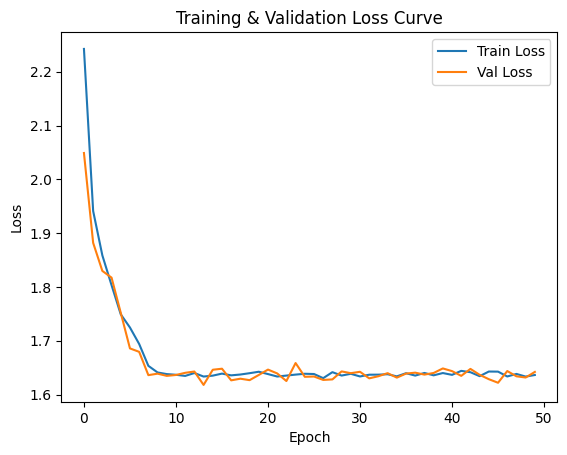

In [ ]:
# Training vall loss curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.show()

In [ ]:
# Plots: the image, The image + the ground truth mask + detection boxes, The image + the predicted mask + predicted boxes
def analyze_sample(model, train_dataset, sample_index):
    img, targets = train_dataset[sample_index]
    fig, axs = plt.subplots(1, 3, figsize=(20, 40), facecolor="#fefefe") 

    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    axs[0].imshow(img.numpy().transpose((1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")

    for mask in targets['masks']:
        box = get_box(mask)
        boxes = np.logical_or(boxes, draw_box(box)) 

    masks = combine_masks(targets['masks'], 0.5)
    detections = combine_masks_boxes(masks, boxes)
    axs[1].imshow(detections)
    axs[1].set_title("Ground truth")
    axs[1].axis("off")

    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    axs[2].imshow(img.cpu().numpy().transpose((1,2,0)))
    
    for mask in preds['masks'].cpu().detach():
        box = get_box(mask[[0]])
        boxes = np.logical_or(boxes, draw_box(box))

    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    mask_threshold = MASK_THRESHOLD_DICT[l.sort_values().index[-1]]
    pred_masks = combine_masks(get_filtered_masks(preds), 0.5)


    detections = combine_masks_boxes(pred_masks, boxes)
    score = iou_map([masks],[pred_masks])
    axs[2].imshow(detections)
    axs[2].set_title(f"Predictions | IoU score: {score:.2f}")
    axs[2].axis("off")
    plt.show()

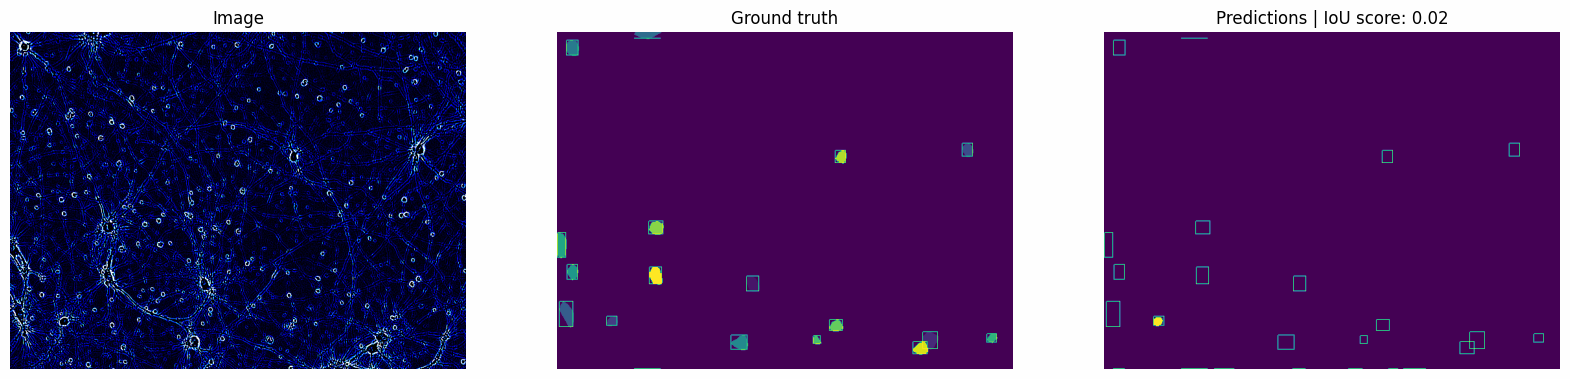

In [32]:
analyze_sample(model, train_dataset, random.randint(1, 500))

In [ ]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert("RGB")

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}

ds_test = CellTestDataset(TEST_PATH, transforms=get_transform(train=False))

In [ ]:
model.eval()

submission = []
for sample in ds_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]

    previous_masks = []
    for i, mask in enumerate(result["masks"]):
        score = result["scores"][i].cpu().item()
        mask = mask.cpu().numpy()
        # Keep only highly likely pixels
        binary_mask = mask > MASK_THRESHOLD
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))

    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
df_sub.head()

,id,predicted
0,7ae19de7bc2a,178040 24 178743 25 179447 25 180151 25 180855...
1,7ae19de7bc2a,40225 2 40927 4 41630 6 42333 7 43037 7 43740 ...
2,7ae19de7bc2a,148229 3 148930 8 149633 10 150335 12 151039 1...
3,7ae19de7bc2a,224978 15 225679 19 226381 21 227083 23 227786...
4,7ae19de7bc2a,165014 10 165716 15 166419 19 167122 21 167825...
